## Part 2 - Neural Network Implementation for Image Segmentation

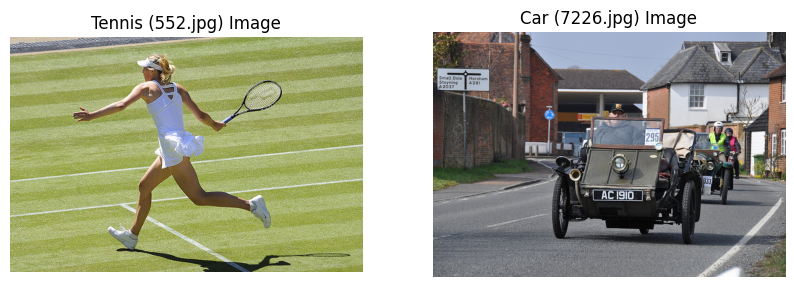

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')

# Load image Google Drive
# image_path = '/content/drive/My Drive/ECSE415_computer_vision/A5/'
image_path = r"C:\Users\theog\Documents\CodingProjects\ECSE415_Computer_Vision\Assignments\A5"
tennis_image = cv2.imread(image_path + r"\Part 2\000000000552.jpg")
car_image = cv2.imread(image_path + r"\Part 2\000000007226.jpg")

# show both images next to each other:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(tennis_image, cv2.COLOR_BGR2RGB))
plt.title("Tennis (552.jpg) Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB))
plt.title("Car (7226.jpg) Image")
plt.axis('off')
plt.show()


### 1. Implement the pre-trained Mask R-CNN and YOLOvSn-seg model and run them on the 552.jpg and 7726.jpg image included in the assignment folder.

### 2. Display the result that shows the bounding boxes, object classes, and segmentations inside each bounding box.


### 3. Repeat steps 1 and 2 for an image of a Montreal street scene that you took with your own camera. 
You can use the image that you acquired for Assignment 4.


### 4. Compare the performance of these two models and explain the steps that Mask R- CNN took to achieve the final result.


